<a href="https://colab.research.google.com/github/Wanita-8943/run/blob/main/1_B3_Train_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [6]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [7]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1067, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 1067 (delta 114), reused 161 (delta 79), pack-reused 837
Receiving objects: 100% (1067/1067), 13.93 MiB | 36.38 MiB/s, done.
Resolving deltas: 100% (611/611), done.
/content/efficientnet_keras_transfer_learning


In [8]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [9]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


43966704/43966704 [==============================] - 0s 0us/step


In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


In [12]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 340
This is the number of trainable layers after freezing the conv base: 2


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 3074      
                                                                 
Total params: 10,786,602
Trainable params: 3,074
Non-trainable params: 10,783,528
_________________________________________________________________


In [14]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 40)   1080        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 40)  160         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [15]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Gender.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,0,V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
1,2,1,7,Y07F,0,Flip_V1.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
2,3,2,7,Y07F,0,V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
3,4,2,7,Y07F,0,Flip_V2.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
4,5,3,7,Y07F,0,V3.jpg,/content/drive/My Drive/TVT_Gender/train/Femal...,Female,Both
...,...,...,...,...,...,...,...,...,...
4745,121,77,25,Y25M,1,Flip_J463.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4746,122,78,25,Y25M,1,J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both
4747,123,78,25,Y25M,1,Flip_J464.jpg,/content/drive/My Drive/TVT_Gender/test/Male/F...,Male,Both
4748,124,79,25,Y25M,1,J465.jpg,/content/drive/My Drive/TVT_Gender/test/Male/J...,Male,Both


In [16]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [17]:
DATA_PATH = "/content/drive/My Drive/TVT_Gender"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/TVT_Gender/train
/content/drive/My Drive/TVT_Gender/validation



#Train

In [18]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Sex',
        class_mode = 'categorical',
        target_size=(height, width),
        batch_size=batch_size)

Found 2850 validated image filenames belonging to 2 classes.
Found 950 validated image filenames belonging to 2 classes.


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-20-7a569d3d450f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 207s 1s/step - loss: 1.2764 - acc: 0.4979 - val_loss: 0.9087 - val_acc: 0.5117
Epoch 2/250
178/178 [==============================] - 21s 114ms/step - loss: 1.1933 - acc: 0.5208 - val_loss: 0.9222 - val_acc: 0.5000
Epoch 3/250
178/178 [==============================] - 25s 140ms/step - loss: 1.1167 - acc: 0.5286 - val_loss: 0.8329 - val_acc: 0.5350
Epoch 4/250
178/178 [==============================] - 22s 120ms/step - loss: 1.0569 - acc: 0.5311 - val_loss: 0.7383 - val_acc: 0.5710
Epoch 5/250
178/178 [==============================] - 25s 139ms/step - loss: 0.9968 - acc: 0.5522 - val_loss: 0.9042 - val_acc: 0.5328
Epoch 6/250
178/178 [==============================] - 26s 142ms/step - loss: 0.9825 - acc: 0.5540 - val_loss: 1.0105 - val_acc: 0.5212
Epoch 7/250
178/178 [==============================] - 25s 135ms/step - loss: 0.9455 - acc: 0.5621 - val_loss: 0.8880 - val_acc: 0.5583
Epoch 8/250
178/178 [=============================

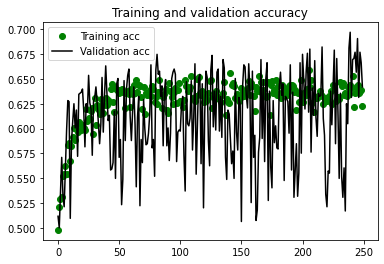

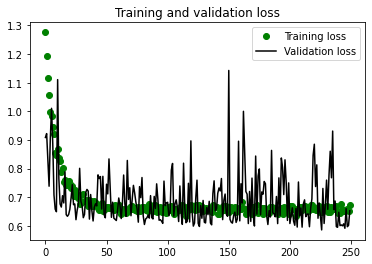

In [21]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
epochs_x

range(0, 250)

#Download the model


In [23]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/1_B3_G1_Freeze_250.h5')

In [ ]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1.1_รอบแรก_Flimpano_Male125_250.h5')